In [1]:
import codecs
import json
import numpy as np
import sklearn

In [2]:
from Scripts.ProcessingEmbeddings import *
import Scripts.utils as utils

In [3]:
#Creating an embeddings object: 400k words, 50 dimensions
glove=Embeddings('Data/glove-wiki-gigaword-300.txt', gensim=False)
#glove_300=Embeddings('glove-wiki-gigaword-300')

Loading Data/glove-wiki-gigaword-300.txt embeddings
vectors shape: (400000, 300), word2idx length: 400000, vocab length: 400000


In [4]:
#Getting the attributes of the embeddings 
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

In [5]:
#Verifying the attributes: there shouldn't be any null values
np.isnan(vectors).any()

False

In [6]:
#Removing puntuation and numbers from the embeddings
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(vectors, word2idx, vocab)

100%|██████████| 400000/400000 [00:00<00:00, 637442.15it/s]


Size of limited vocabulary: 327185


In [7]:
#Checking if vector are normalized
np.apply_along_axis(np.linalg.norm, 1, vectors_cleaned)
#They are not!

array([5.18139682, 5.45449219, 5.91459155, ..., 5.73745479, 6.25541744,
       3.3774816 ])

## Hard-Debias Algorithm

#### Preliminaries

In [8]:
from Scripts.HardDebias import *

In [9]:
#Gender specific vocabulary from Bolukbasi's paper.
gender_specific = []
female_vocab = []
male_vocab = []
with open('./Data/male_word_file.txt') as f:
    male_vocab = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        female_vocab.append(l.strip())

gender_specific = female_vocab+female_vocab

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))


In [10]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets={
    "gender" : [
    ['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
    ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'],['aunt', 'uncle']],
    
    "race":[
		["black", "caucasian", "asian", "hispanic"],
		["african", "caucasian", "asian", "hispanic"],
		["black", "white", "asian", "latino"],
		["africa", "europe", "asia", "mexico"],
		["africa", "america", "china", "latin-america"],
    ]
	}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], [
            "Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], [
            "grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], [
            "wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], [
            "brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman",
                                                        "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], [
            "fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], [
            "gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], [
            "his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], [
            "men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]],

    "race": [
        ["black", "caucasian", "asian"],
      	["african", "caucasian", "asian"],
      	["black", "white", "asian"],
      	["africa", "america", "asia"],
      	["africa", "america", "china"],
      	["africa", "europe", "asia"]
    ]}

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


In [11]:
#Lists of names for validation
#Adapted from Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
   
}
#Following Bolukbasi et al. Implementing notebook: https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
#names_group1 = [names[2 * i] for i in range(len(names) // 2)]
#names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]



In [12]:
#Preparing the definite sets for debiasing
def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])

## Evaluation of Slight changes to the algorithm

In [13]:
from Scripts.Visualization import *
from Scripts.Evaluation import *

### Setting up parameters and combinations

In [14]:
# Importing the dataset with all parameter combinations: 
# norm_direction is a parameter that determines whether the bias direction is normalized or not
# normalize is a parameter that determines whether the word vectors are normalized before or after debiasing
# centralize is a parameter that determines whether the word vectors are centered before using PCA to find the bias subspace
import pandas as pd
parameters = pd.read_csv('Data/all_parameter_combinations.csv', header=0)
parameters


norm_direction normalize  centralize
0            False      None       False
1            False      None        True
2            False     after       False
3            False     after        True
4            False    before       False
5            False    before        True
6             True      None       False
7             True      None        True
8             True     after       False
9             True     after        True
10            True    before       False
11            True    before        True

In [15]:
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']
occupations = ['assistant', 'secretary', 'data scientist', 'scientist', 'politician', 'janitor', 'hairdresser', 'teacher', 'bartender', 'midwife', 'doctor', 'ballerina', 'dancer', 'pediatrician', 'surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists', 'carpenter', 'clerk', 'manager', 'supervisor', 'driver',
               'software developer', 'lawyer', 'pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro', 'lecturer', 'salesperson', 'homemaker', 'receptionist', 'librarian', 'nanny', 'bookkeeper', 'stylist', 'housekeeper', 'guidance counselor', 'skipper', 'protege', 'philosopher', 'captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher', 'pilot', 'boss']
neutral_words=neutral_words

In [16]:
# gets the debiased vectors for all the 12 possible scenarios and stores them on a dataframe
def get_debiased_vectors(vectors, dict_vectors, word2idx_cleaned,
                         vocab_cleaned,
                         equalizing_lists,
                         def_set, parameters_df):
    grand_dictionary = {}
    #loop over indexes of the df
    for i in range(len(parameters_df)):
        #run the hard_debias function with the parameters of the row and generate a dictionary with the results: key=index, value:dictionary, key=name (vectors, vocab, word2idx), value: the result of the function
        debiased_vectors, debiased_vocab, debiased_word2idx, debiased_dict= hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists, 
                             def_set,
                             1,
                             normalize_dir=parameters_df.iloc[i][0],
                             normalize=parameters_df.iloc[i][1],
                             centralizing=parameters_df.iloc[i][2])
       
        #add the variables to the grand dictionary
        grand_dictionary[i] = {'vectors': debiased_vectors, 'vocab':debiased_vocab, 'word2idx':debiased_word2idx, 'dict':debiased_dict}
                    
        
    return grand_dictionary

In [17]:
grand_dict=get_debiased_vectors(vectors, dict_vectors, word2idx_cleaned,
                     vocab_cleaned,
                     equalizing_lists['gender'],
                     def_set_gender, parameters)


Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components


### Bias Pre-Post of selected words. 
Using the original and debiased vectors, I calculate bias scores in two ways: 
1. Simple Bias Score: cos(v, she_embed)-cos(v, he_embed) for every v in the vocabulary
2. Direct bias score: following Bolukbasi et al. 2016

With this, I get a measure of the debiasing effects per word or the chosen list. 

In [18]:
gender_bias_original = compute_gender_simple_bias(
    dict_vec_cleaned, he_embed, she_embed)

def get_debiased_vectors_scores_plots(grand_dict,dict_vectors,parameters_df,he_embed,she_embed):
    scores_dictionary = {}
    
    #loop over indexes of the df
    for i in range(len(parameters_df)):
        #debiased_vectors=grand_dict[i]['vectors'] 
        #debiased_vocab=grand_dict[i]['vocab']
        #debiased_word2idx=grand_dict[i]['word2idx']
        debiased_dict = grand_dict[i]['dict']

        # Using the gender bias function to compute the bias of all the words in the limited dataset
        #We create a dictionary with the word as key and the bias as value
        gender_bias_after_debiasing= compute_gender_simple_bias(debiased_dict, he_embed, she_embed)
        
        gender_direction = identify_bias_subspace(dict_vectors, def_set_gender, 1, centralizing=parameters_df.iloc[i][2])
        if parameters_df.iloc[i][0]:
            gender_direction = utils.normalize(gender_direction)
        
        #use compute_direct_bias to get the scores
        direct_gender_bias_original = compute_similarity_to_bias_direction(
            dict_vectors, gender_direction)
        direct_gender_bias_debiased = compute_similarity_to_bias_direction(
            debiased_dict, gender_direction)
        
        scores_dictionary[i] = {'simple_bias': gender_bias_after_debiasing,
                                'direct_bias_original': direct_gender_bias_original, 
                                'direct_bias_debiased': direct_gender_bias_debiased}
    return scores_dictionary


In [19]:
scores_dictionary = get_debiased_vectors_scores_plots(
    grand_dict,dict_vectors, parameters, he_embed, she_embed)


Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components
Length of vectors set: 11
Running PCA with 1 components
Length of vectors set: 22
Running PCA with 1 components


In [20]:
#Function to get a bar plot comparing pre-post scores for chosen words
def getting_plots_simple_scores(grand_dict,test_words, gender_bias_original, scores_dictionary, parameters_df):
    bias_df_all=pd.DataFrame()
    for i in range(len(scores_dictionary)):
        debiased_vocab=grand_dict[i]['vocab']
        gender_bias_debiased=scores_dictionary[i]['simple_bias']
        bias_df = get_bias_score_df_from_list(
            gender_bias_original, gender_bias_debiased, test_words, vocab_cleaned, debiased_vocab)
        #print("______________________________________")
        #print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        #plot_bias_bar(bias_df, plot_title="Exp_"+str(i), words_title='words')
        bias_df['experiment'] = "Exp_"+str(i)+' : ' + str(parameters_df.iloc[i][0])+' / '+str(parameters_df.iloc[i][1])+' / '+str(parameters_df.iloc[i][2])
    #merge all the dataframes
        bias_df_all = pd.concat([bias_df_all, bias_df])
    return bias_df_all


In [21]:
#Plots for occupations
bias_df_all_occupations= getting_plots_simple_scores(grand_dict,occupations,gender_bias_original,scores_dictionary, parameters)

In [22]:
#get plots of all the bias_df_all faceted by experiment
fig = px.bar(bias_df_all_occupations, x='index', y='value', color='variable', barmode='group', facet_col='experiment', facet_col_wrap=2,
           title='Bias scores for occupations',
           height=1200, width=1000)
fig.show()


In [23]:
#Plots for occupations
bias_df_all_neutral= getting_plots_simple_scores(grand_dict,neutral_words,gender_bias_original,scores_dictionary, parameters)

In [24]:
#get plots of all the bias_df_all faceted by experiment
fig = px.bar(bias_df_all_neutral, x='index', y='value', color='variable', barmode='group', facet_col='experiment', facet_col_wrap=2,
             title='Bias scores for occupations',
             height=1200, width=1000)
fig.show()


In [25]:
#Function to get a bar plot comparing pre-post scores for chosen words
def getting_plots_simple_scores(grand_dict, test_words, scores_dictionary, parameters_df):
    bias_df_all = pd.DataFrame()
    for i in range(len(scores_dictionary)):
        debiased_vocab = grand_dict[i]['vocab']
        direct_gender_bias_original = scores_dictionary[i]['direct_bias_original']
        gender_bias_debiased = scores_dictionary[i]['direct_bias_debiased']
        bias_df = get_bias_score_df_from_list(
            direct_gender_bias_original, gender_bias_debiased, test_words, vocab_cleaned, debiased_vocab)
        #print("______________________________________")
        #print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        #plot_bias_bar(bias_df, plot_title="Exp_"+str(i), words_title='words')
        bias_df['experiment'] = "Exp_"+str(i)+' : ' + str(parameters_df.iloc[i][0])+' / '+str(
            parameters_df.iloc[i][1])+' / '+str(parameters_df.iloc[i][2])
    #merge all the dataframes
        bias_df_all = pd.concat([bias_df_all, bias_df])
    return bias_df_all


In [26]:
#Plots for occupations
direct_bias_occupations= getting_plots_simple_scores(grand_dict,neutral_words,scores_dictionary, parameters)
direct_bias_occupations.value=direct_bias_occupations.value.astype(float)


In [27]:
#get plots of all the bias_df_all faceted by experiment
fig = px.bar(direct_bias_occupations, x='index', y='value', color='variable', barmode='group', facet_col='experiment', facet_col_wrap=2,
             title='Bias scores for occupations',
             height=1600, width=1000)
fig.show()


In [28]:
#get average bias score for each experiment
average_scores=direct_bias_occupations[['variable', 'value', 'experiment']].groupby(['experiment', 'variable']).mean()
average_scores.reset_index(inplace=True)
average_scores.sort_values(by=['variable', 'experiment'],ascending=False, inplace=True)
average_scores=average_scores.reset_index(drop=True)

In [29]:
average_scores


experiment        variable         value
0      Exp_9 : True / after / True  original_score  1.249395e-02
1     Exp_8 : True / after / False  original_score -9.579820e-02
2       Exp_7 : True / None / True  original_score  1.249395e-02
3      Exp_6 : True / None / False  original_score -9.579820e-02
4    Exp_5 : False / before / True  original_score  1.249395e-02
5   Exp_4 : False / before / False  original_score -9.579820e-02
6     Exp_3 : False / after / True  original_score  1.249395e-02
7    Exp_2 : False / after / False  original_score -9.579820e-02
8    Exp_11 : True / before / True  original_score  1.249395e-02
9   Exp_10 : True / before / False  original_score -9.579820e-02
10     Exp_1 : False / None / True  original_score -1.249394e-02
11    Exp_0 : False / None / False  original_score -9.613787e-02
12     Exp_9 : True / after / True  debiased_score  8.699725e-03
13    Exp_8 : True / after / False  debiased_score  1.250728e-03
14      Exp_7 : True / None / True  debiased_score  8.699725e-03
15     Exp_6 : True / None / False  debiased_score  1.250728e-03
16   Exp_5 : False / before / True  debiased_score  8.699724e-03
17  Exp_4 : False / before / False  debiased_score  1.250705e-03
18    Exp_3 : False / after / True  debiased_score  8.699724e-03
19   Exp_2 : False / after / False  debiased_score  1.250704e-03
20   Exp_11 : True / before / True  debiased_score  8.699725e-03
21  Exp_10 : True / before / False  debiased_score  1.250727e-03
22     Exp_1 : False / None / True  debiased_score -8.699716e-03
23    Exp_0 : False / None / False  debiased_score -1.967763e-08

In [30]:
#plot average scores
fig = px.bar(average_scores, y='experiment', x='value', color='variable', barmode='group', orientation='h',
             height=800,
             title='Average bias scores for occupations')
fig.update_yaxes(type='category')
fig.update_xaxes(range=[-0.2, 0.2])
fig.show()


In [31]:
direct_bias_occupations


index        variable     value                     experiment
0      manager  original_score -0.228343   Exp_0 : False / None / False
1    executive  original_score -0.120126   Exp_0 : False / None / False
2       doctor  original_score -0.181655   Exp_0 : False / None / False
3       lawyer  original_score -0.116731   Exp_0 : False / None / False
4   programmer  original_score -0.123213   Exp_0 : False / None / False
..         ...             ...       ...                            ...
89     violent  debiased_score  0.017632  Exp_11 : True / before / True
90   terrorist  debiased_score  0.011196  Exp_11 : True / before / True
91       dirty  debiased_score  0.012027  Exp_11 : True / before / True
92  uneducated  debiased_score -0.003938  Exp_11 : True / before / True
93    educated  debiased_score  0.028764  Exp_11 : True / before / True

[1128 rows x 4 columns]

## Visualizing Clusters of feminine and masculine words
Debiasing algorithms are tested through the visualization of the feminine vs masculine clusters. When the clusters are very mingled together, it is said that the debiasing algorithm was successful (as the clusters are no longer linearly separable).

I plotted the clusters for all the experiments and interestingly, there are barely any differences between them. I'll still have to check whether the clustering algorithm is working properly. 


In [32]:
c_w2i, c_vocab, female_words, male_words, y_true=utils.getting_biased_words(gender_bias_original, def_sets['gender'], 500, word2idx)

In [33]:
female_vocab_emb= list(w for w in female_vocab if w in vocab_cleaned)
male_vocab_emb= list(w for w in male_vocab if w in vocab_cleaned)

In [64]:

def cluster_and_visualize(words, X, title, y_true, random_state, num=2):
    """"
    Function to cluster the words depending on their label. Following Gonen et al. (2019)
    ----
    :param words: words to be plotted
    :param X1: vectors to be plotted
    :param title: title of the plot
    :param y_true: true labels
    :param num: number of clusters
    :return: plot
    """

    kmeans = KMeans(n_clusters=num, random_state=random_state,
                    n_init=10).fit(X)
    y_pred = kmeans.predict(X)
    correct = [1 if item1 == item2 else 0 for (
        item1, item2) in zip(y_true, y_pred)]
    
    precision = sum(correct)/float(len(correct))
    print('precision', precision)
    _, axs = plt.subplots(1, 1, figsize=(6, 3))
    ax = visualize(X, y_true, axs, title, random_state)
    return ax


In [68]:
%matplotlib inline
def visualizing_all_clusters(grand_dict,parameters_df,word_list, y_true, random_state=42):
    precisions=[] 
    
    fig, axs= plt.subplots(2, 3, figsize=(18, 10))
    for i in range(len(parameters_df)):
        debiased_vectors=grand_dict[i]['vectors'] 
        #debiased_vocab=grand_dict[i]['vocab']
        debiased_word2idx=grand_dict[i]['word2idx']
        #debiased_dict = grand_dict[i]['dict']
        gendered_vectors = utils.extract_vectors(
            word_list, debiased_vectors, debiased_word2idx)

        print('Experiment_'+str(i), ', normalize_direction:',
          parameters_df.iloc[i][0], ', normalize_vectors:', parameters_df.iloc[i][1], ', centralize:', parameters_df.iloc[i][2])
        ax = fig.add_subplot(4, 3, i+1)
        ax=cluster_and_visualize(word_list, np.array(gendered_vectors), 
                                            title=('Glove_Exp'+str(i)+':' + str(parameters_df.iloc[i][0])+"/" + str(parameters_df.iloc[i][1])+"/"+str(parameters_df.iloc[i][2])), 
                                            y_true=y_true, 
                                            random_state=random_state                                            
                                            )
        #precisions.append(precision)
        #add the plot to a grid in fig
        
        #ax.plot()

        #axs.imshow(ax.image[0])
        #axs.set_title('Exp_'+str(i)+': '+str(parameters_df.iloc[i][0])+'/'+str(parameters_df.iloc[i][1])+'/'+str(parameters_df.iloc[i][2]))    
        
    #fig.savefig('clusters_internal_workings.png', bbox_inches='tight')
    #return precisions


precision 1.0


<AxesSubplot:title={'center':'GloVe_original'}>

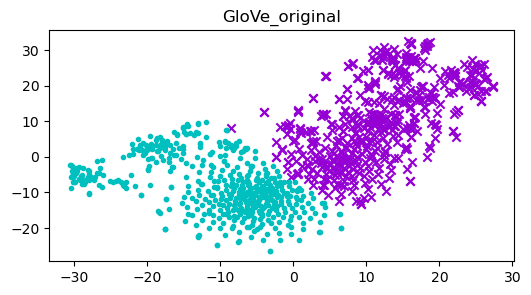

In [66]:

gendered_vectors = utils.extract_vectors(
    male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      np.array(gendered_vectors), 'GloVe_original', y_true, random_state=42)


Experiment_0 , normalize_direction: False , normalize_vectors: None , centralize: False
precision 0.313
Experiment_1 , normalize_direction: False , normalize_vectors: None , centralize: True
precision 0.31
Experiment_2 , normalize_direction: False , normalize_vectors: after , centralize: False
precision 0.685
Experiment_3 , normalize_direction: False , normalize_vectors: after , centralize: True
precision 0.312
Experiment_4 , normalize_direction: False , normalize_vectors: before , centralize: False
precision 0.686
Experiment_5 , normalize_direction: False , normalize_vectors: before , centralize: True
precision 0.688
Experiment_6 , normalize_direction: True , normalize_vectors: None , centralize: False
precision 0.313
Experiment_7 , normalize_direction: True , normalize_vectors: None , centralize: True
precision 0.31
Experiment_8 , normalize_direction: True , normalize_vectors: after , centralize: False
precision 0.685
Experiment_9 , normalize_direction: True , normalize_vectors: afte

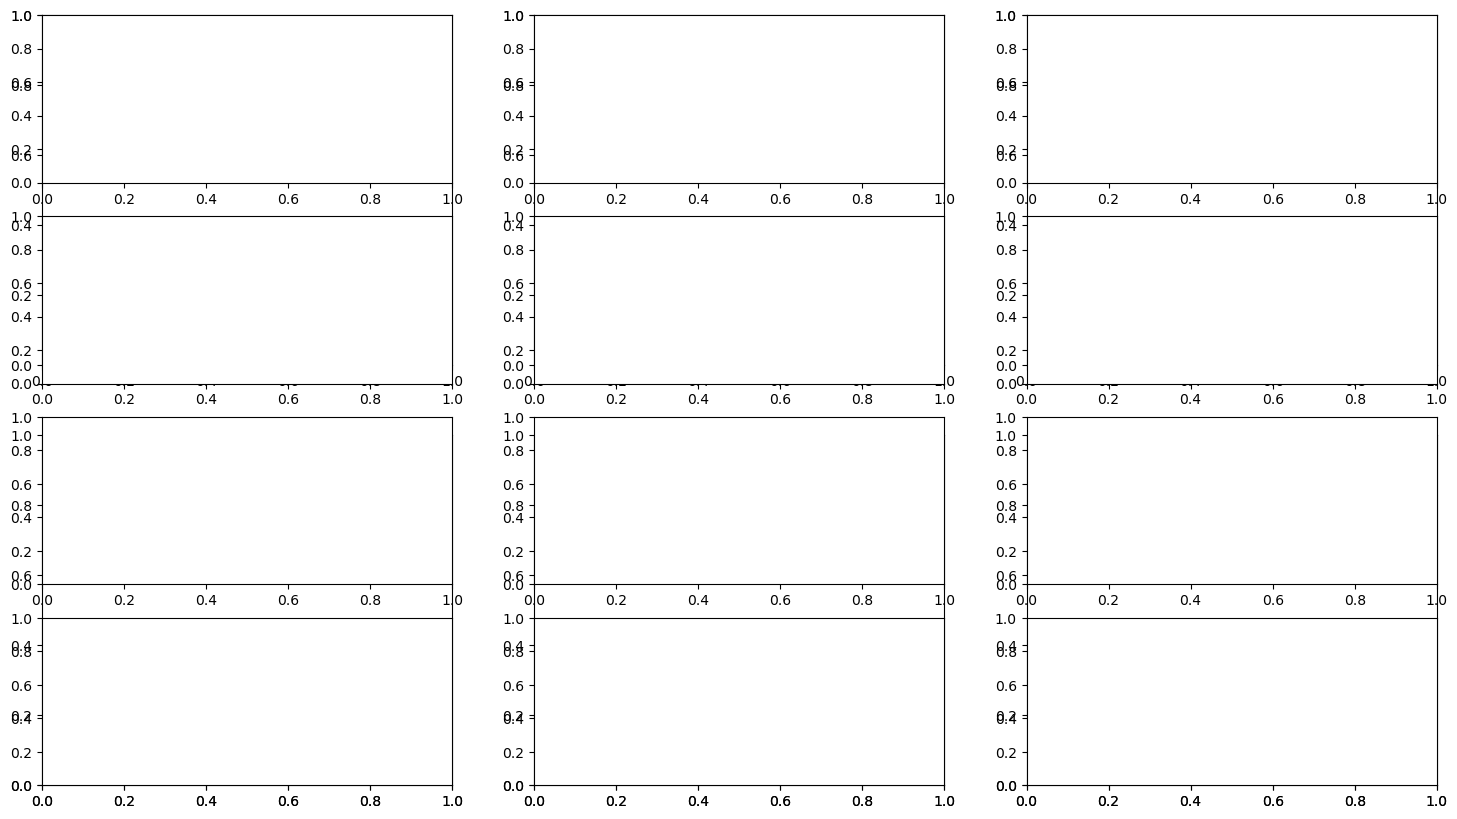

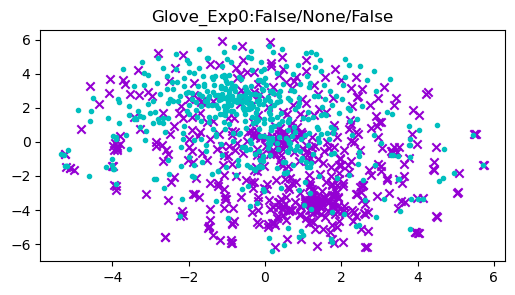

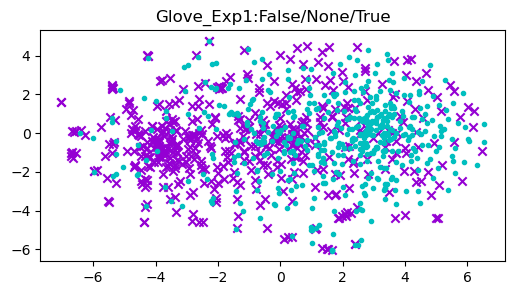

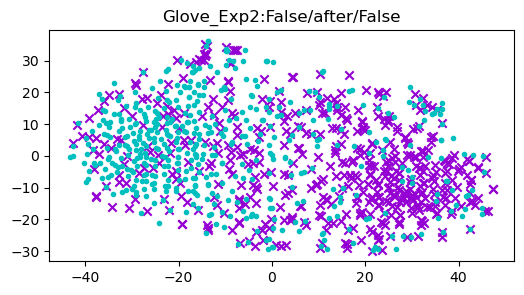

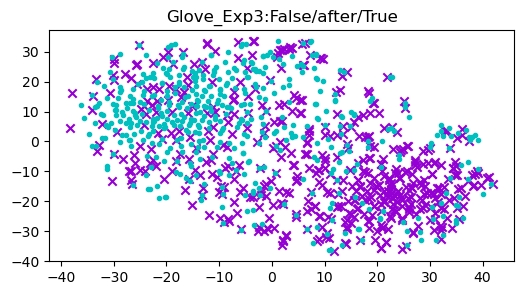

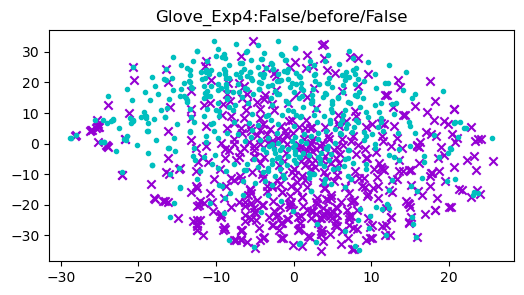

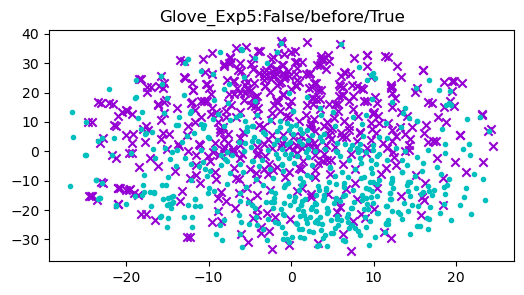

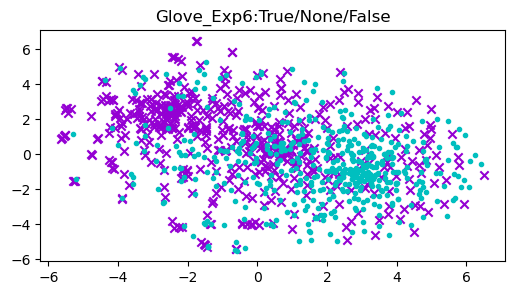

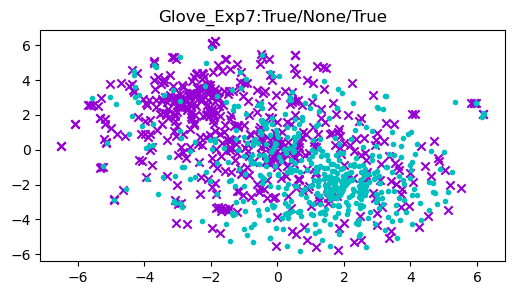

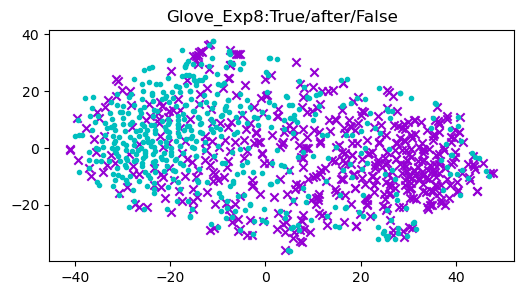

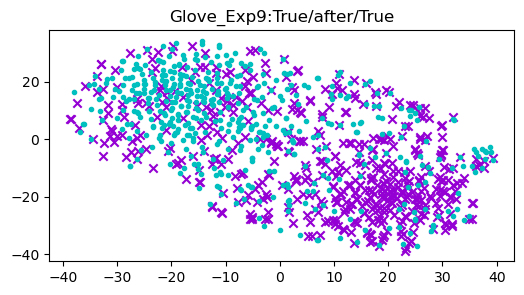

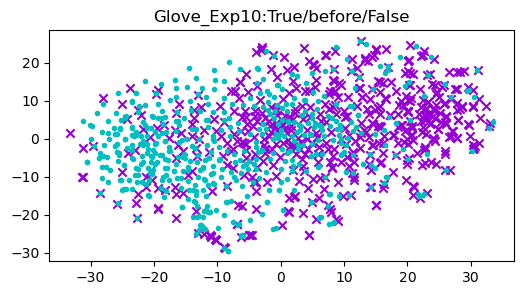

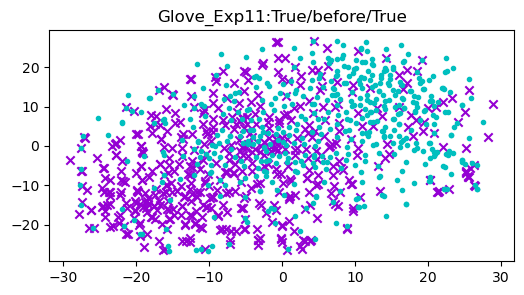

In [69]:
precisions=visualizing_all_clusters(grand_dict, parameters,
                         male_words + female_words, y_true)


### Random Words Clusters
Although debiasing algorithms transform all the embedding vectors, rarely do they report changes in random words, here I explore the closest words to a random list of words (following Ravfogel). I then plot the original neighbors in the debiased embeddings to evaluate what happened to the original clusters

In [37]:
from collections import defaultdict
from sklearn.manifold import TSNE
import numpy as np
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=20)

#setting parameters for the gensim method "most_similar"
topn = 3


In [38]:
random_words


array(['clouds', 'italy', 'anymore', 'cardinals', 'honest', 'eventual',
       'community', 'staying', 'sadr', 'vertical', 'henry', 'love',
       'rubin', 'drawn', 'monument', 'breast', 'jeffrey', 'pass',
       'rushed', 'maryland'], dtype='<U18')

In [39]:
def get_random_words_clusters(grand_dict, vectors_cleaned,vocab_cleaned, parameters_df, random_words, topn):
    model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)

    for i in range(len(parameters_df)):
        debiased_vectors=grand_dict[i]['vectors'] 
        debiased_vocab=grand_dict[i]['vocab']
        model_debiased = create_KeyedVectors(debiased_vectors, debiased_vocab, 300)

        words_before_after=finding_neighbors_before_after(random_words, model_original, model_debiased, topn=topn)
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        print(words_before_after)
        


In [40]:
get_random_words_clusters(grand_dict, vectors_cleaned,vocab_cleaned, parameters, random_words, topn)

----------------------------------
word: clouds
 most-similar-before: ('cloud', 'fog', 'dust')
 most-similar-after: ('encephalitis', 'longtime', 'dprk')
----------------------------------
word: italy
 most-similar-before: ('italian', 'rome', 'spain')
 most-similar-after: ('trust', 'decades', 'best')
----------------------------------
word: anymore
 most-similar-before: ('nobody', 'anybody', 'else')
 most-similar-after: ('sunglasses', 'sound', 'hobby')
----------------------------------
word: cardinals
 most-similar-before: ('braves', 'phillies', 'astros')
 most-similar-after: ('ahl', 'culminated', 'rushed')
----------------------------------
word: honest
 most-similar-before: ('forthright', 'straightforward', 'truthful')
 most-similar-after: ('appearing', 'tally', 'nicole')
----------------------------------
word: eventual
 most-similar-before: ('elimination', 'demise', 'withdrawal')
 most-similar-after: ('mcintosh', 'rocky', 'principles')
----------------------------------
word: commu

In [41]:
def plot_random_words_clusters(parameters_df, random_words, topn):
    model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)
    for i in range(len(parameters_df)):
        debiased_vectors = grand_dict[i]['vectors']
        debiased_vocab = grand_dict[i]['vocab']
        model_debiased = create_KeyedVectors(
            debiased_vectors, debiased_vocab, 300)
        
        #This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
        keys = random_words
        embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
            keys, model_original, model_debiased, topn)

        n, m, k = embedding_clusters.shape
        tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                                init='pca', n_iter=3500, random_state=42)
        embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
                                embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
                                db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        print('Experiment_'+str(i), ', normalize_direction:', parameters_df.iloc[i][0], ', normalize_vectors:',parameters_df.iloc[i][1], ', centralize:',parameters_df.iloc[i][2])
        
        if i==0:
            tsne_plot_similar_words('Similar words before Debiasing',
                                keys, embeddings_en_2d, word_clusters, 0.7)


            tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)
        else:
            tsne_plot_similar_words('Similar words after Debiasing',
                                    keys, db_embeddings_en_2d, word_clusters, 0.7)


Experiment_0 , normalize_direction: False , normalize_vectors: None , centralize: False


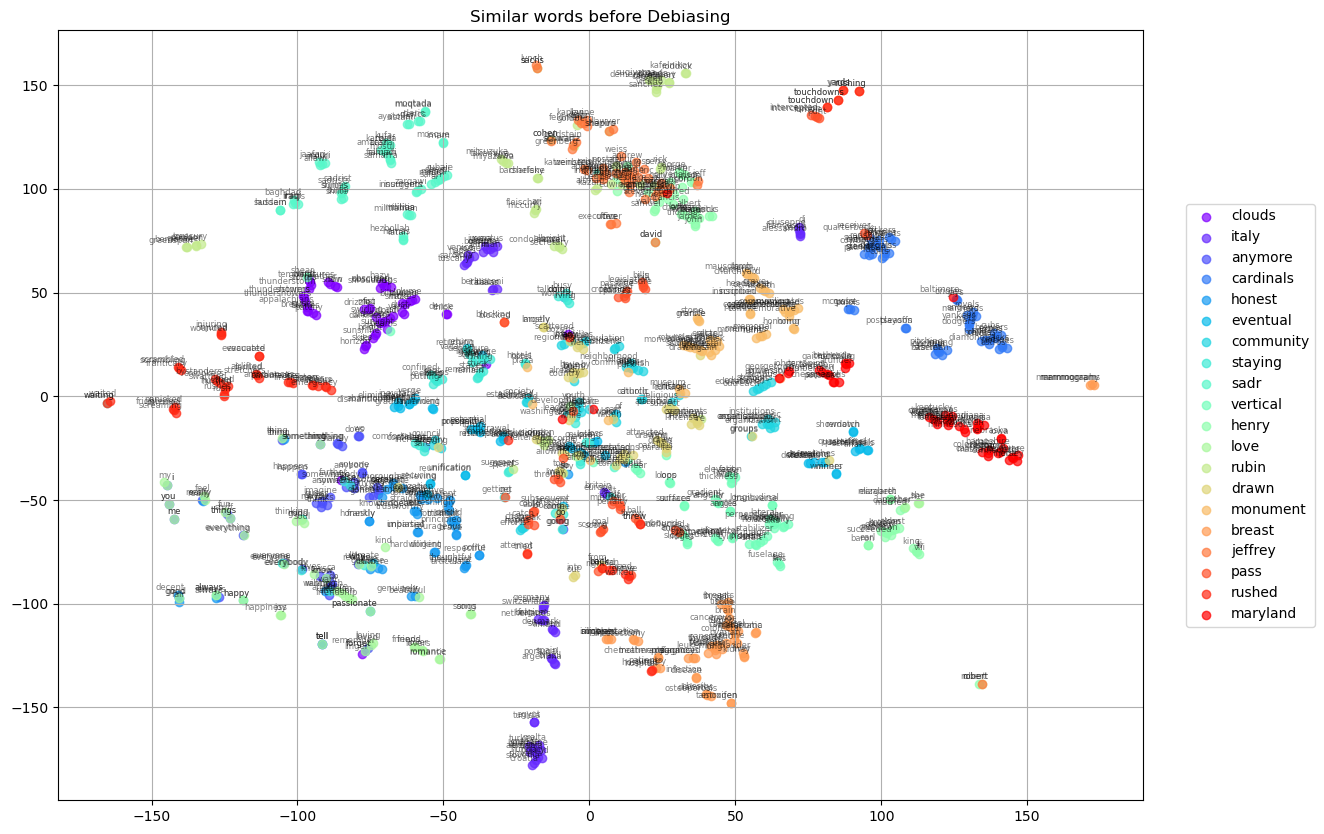

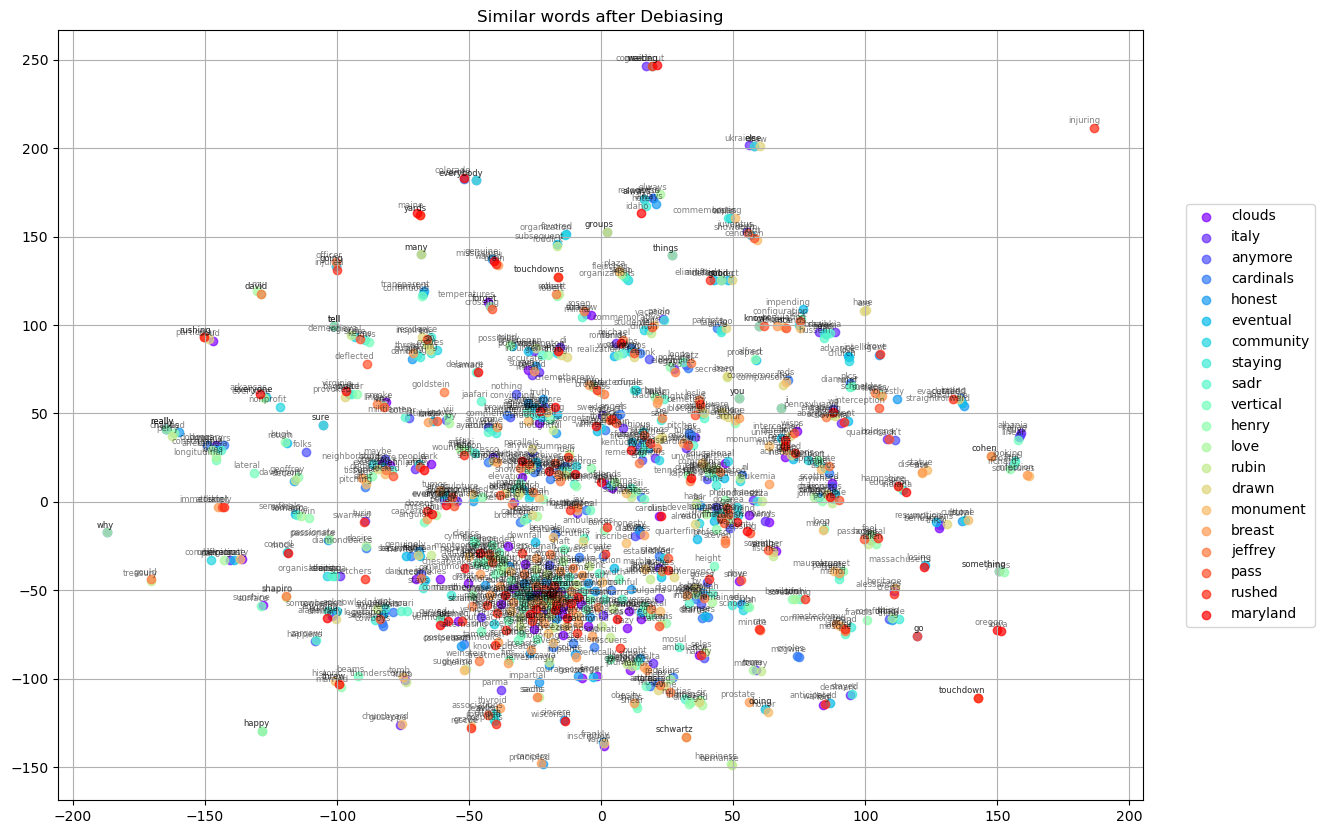

Experiment_1 , normalize_direction: False , normalize_vectors: None , centralize: True


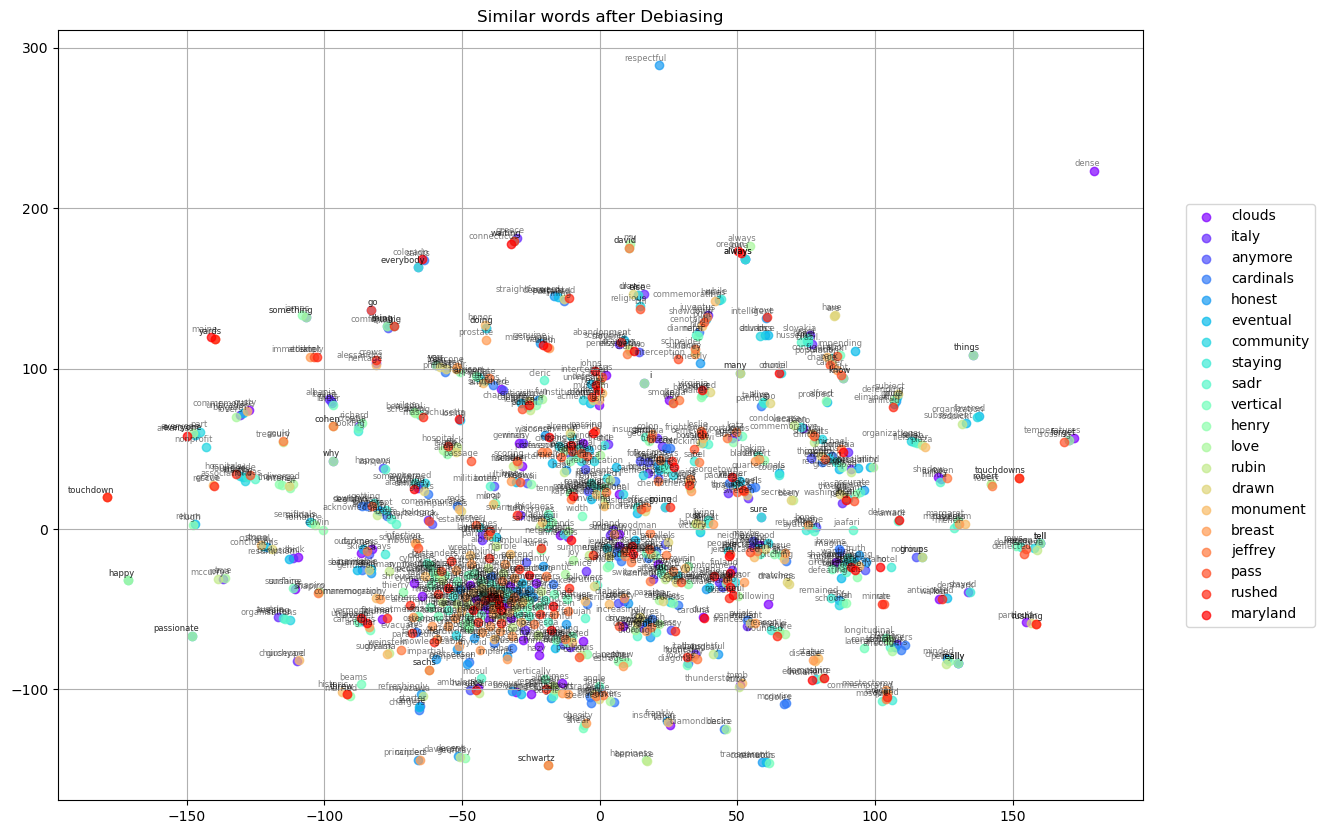

Experiment_2 , normalize_direction: False , normalize_vectors: after , centralize: False


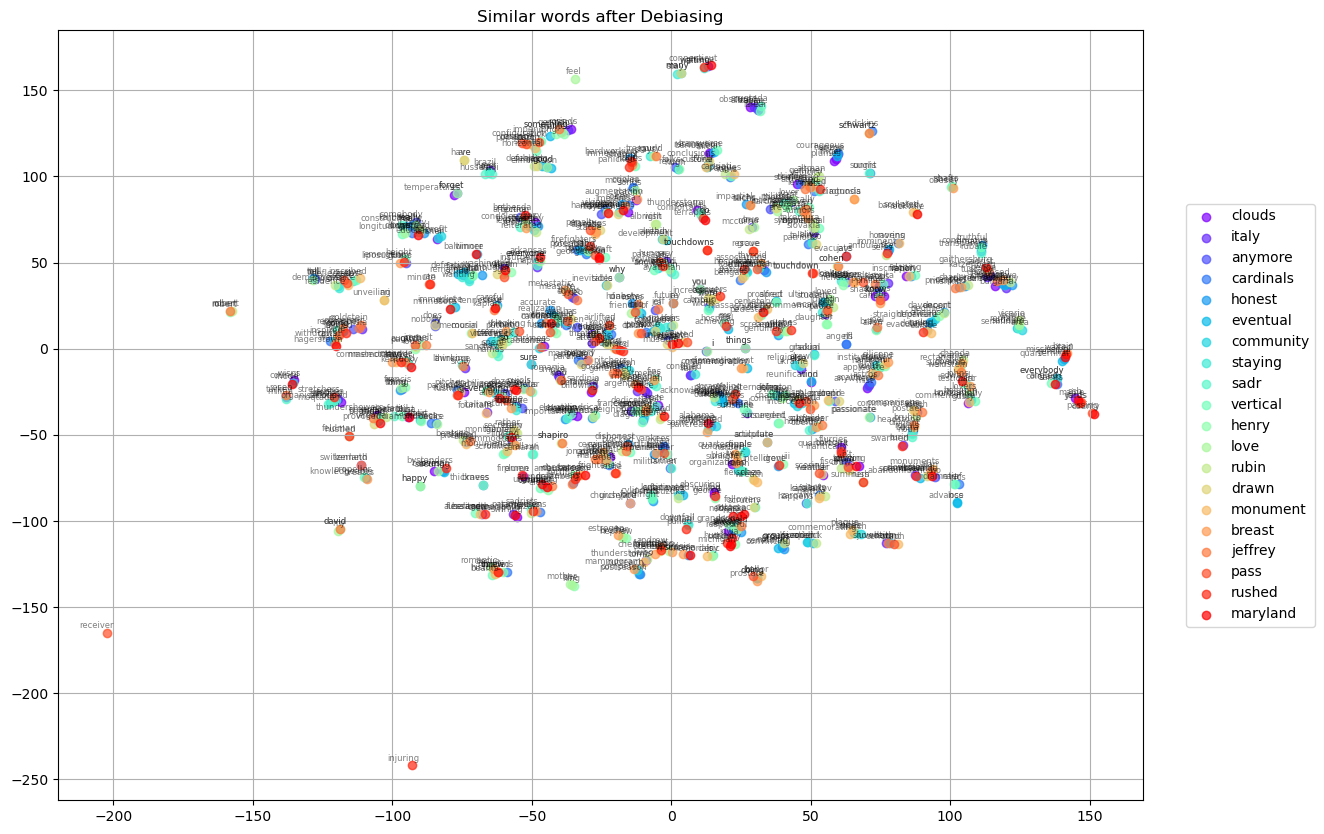

Experiment_3 , normalize_direction: False , normalize_vectors: after , centralize: True


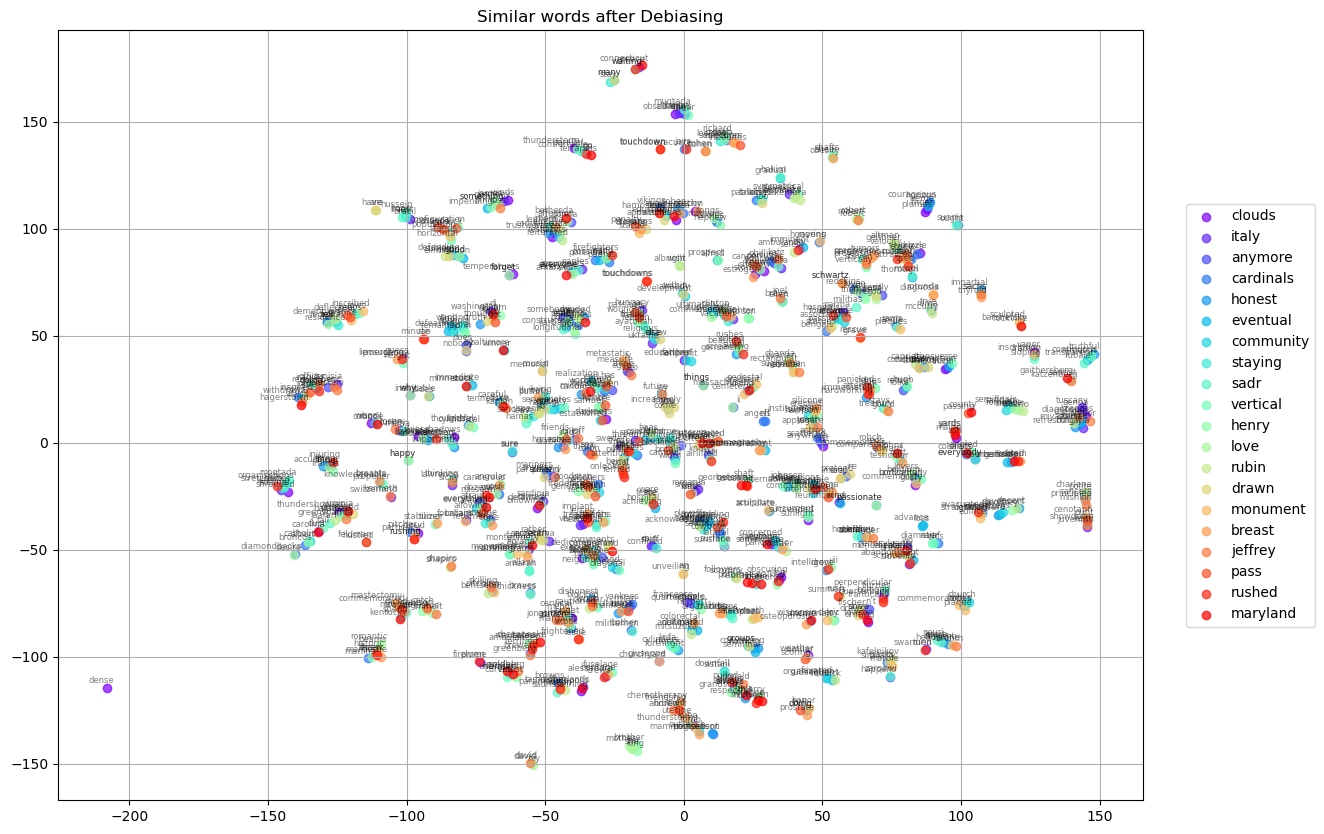

Experiment_4 , normalize_direction: False , normalize_vectors: before , centralize: False


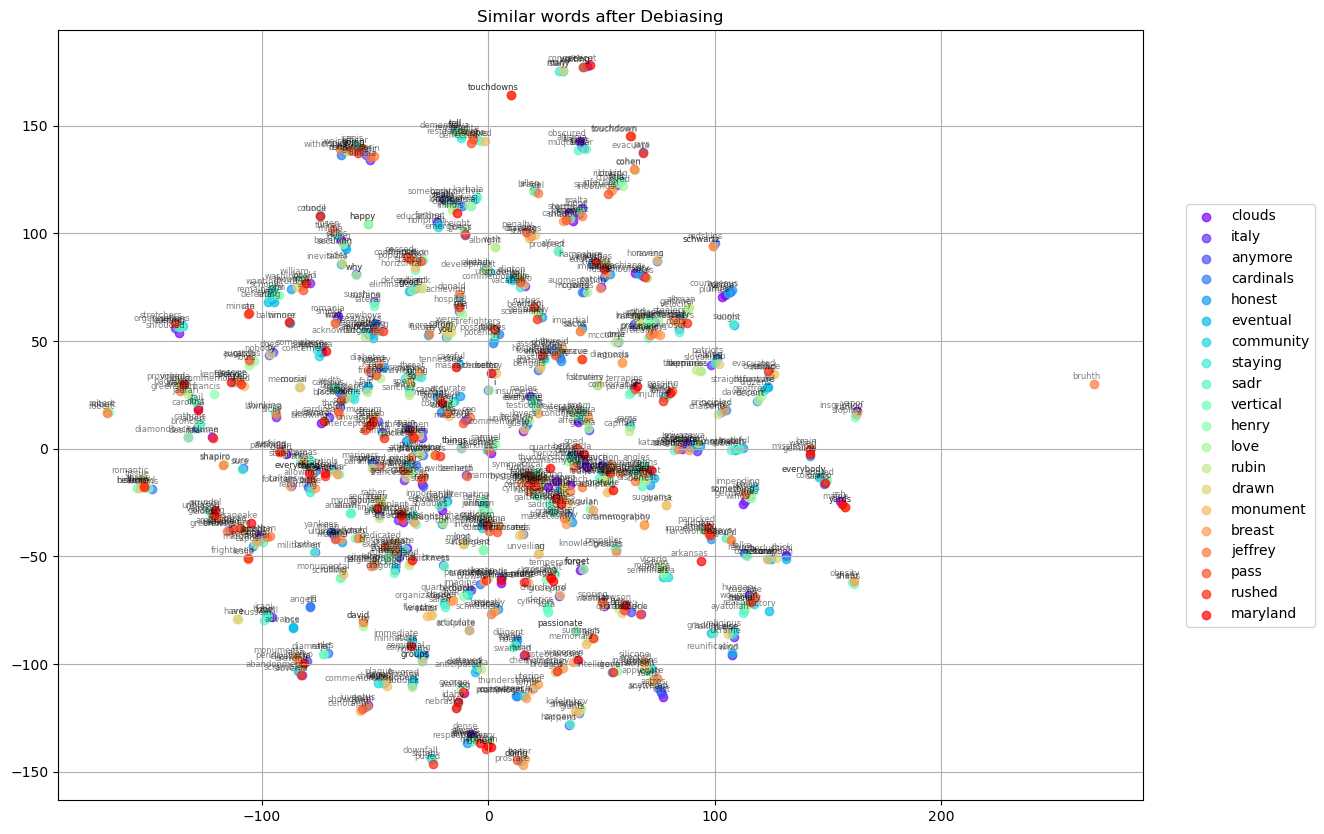

Experiment_5 , normalize_direction: False , normalize_vectors: before , centralize: True


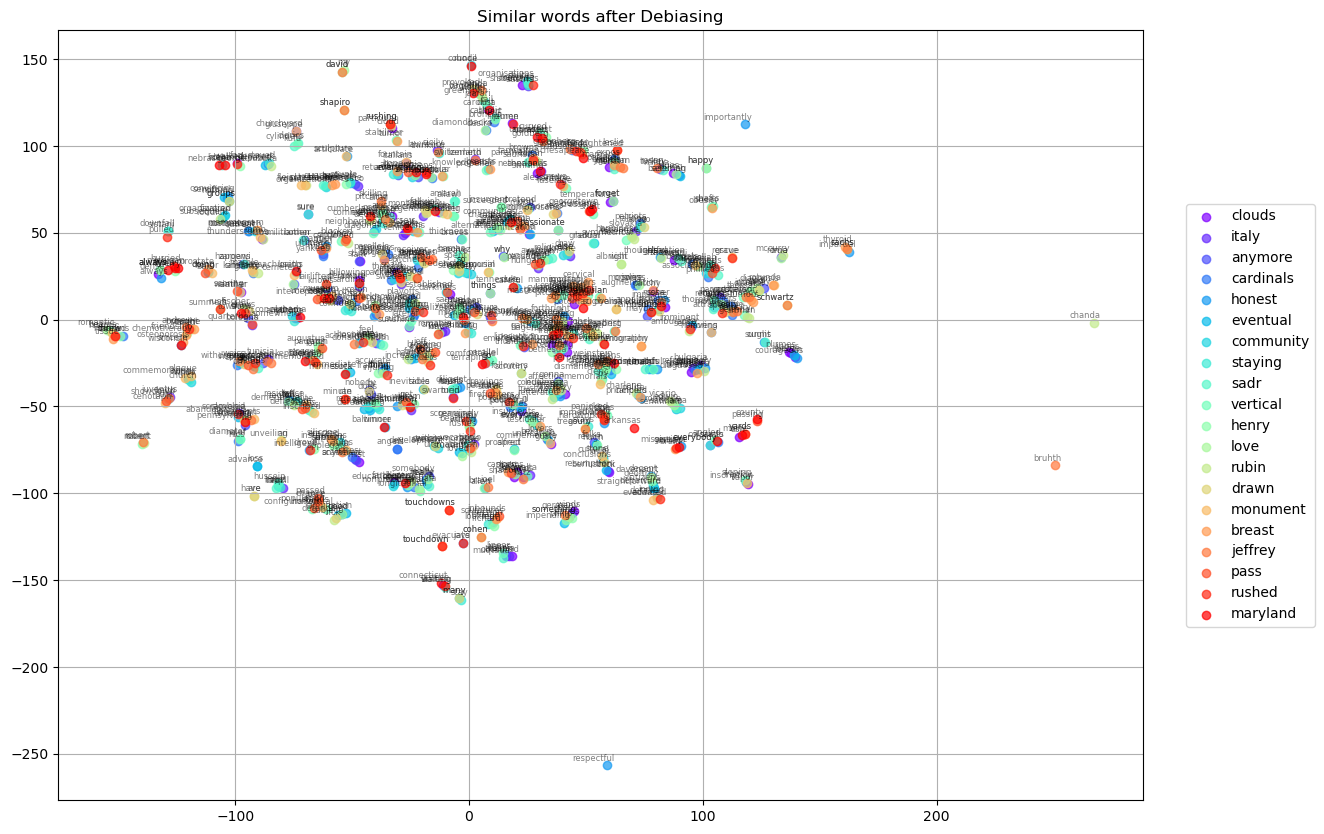

Experiment_6 , normalize_direction: True , normalize_vectors: None , centralize: False


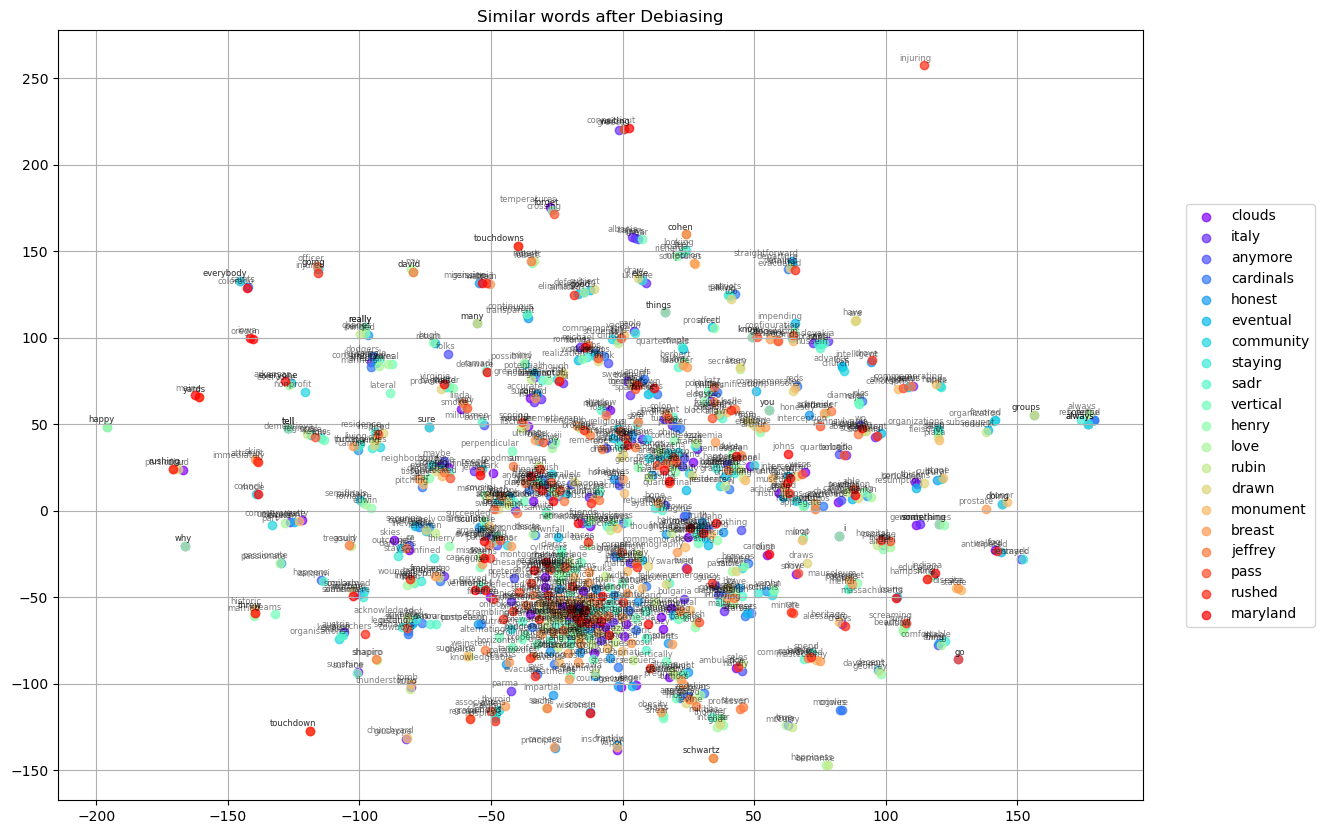

Experiment_7 , normalize_direction: True , normalize_vectors: None , centralize: True


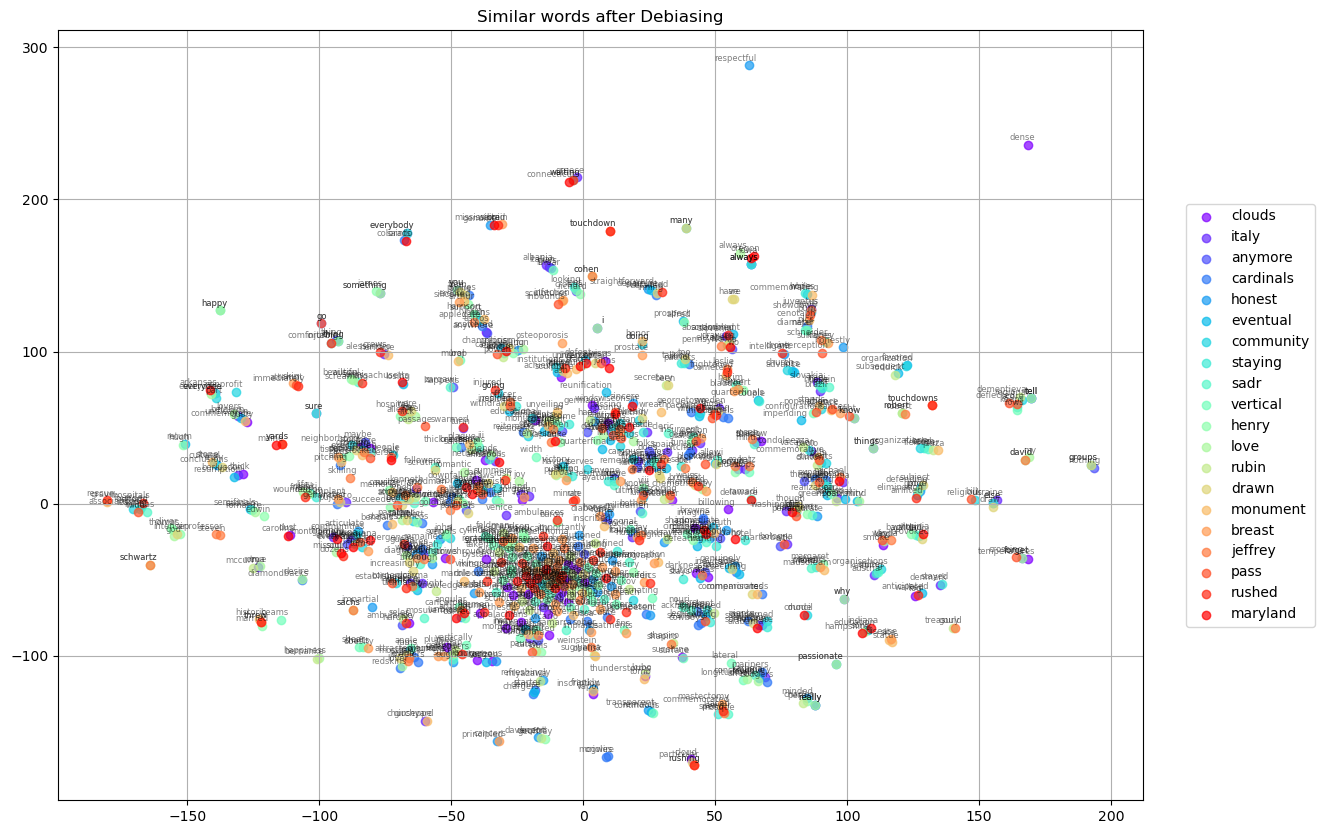

Experiment_8 , normalize_direction: True , normalize_vectors: after , centralize: False


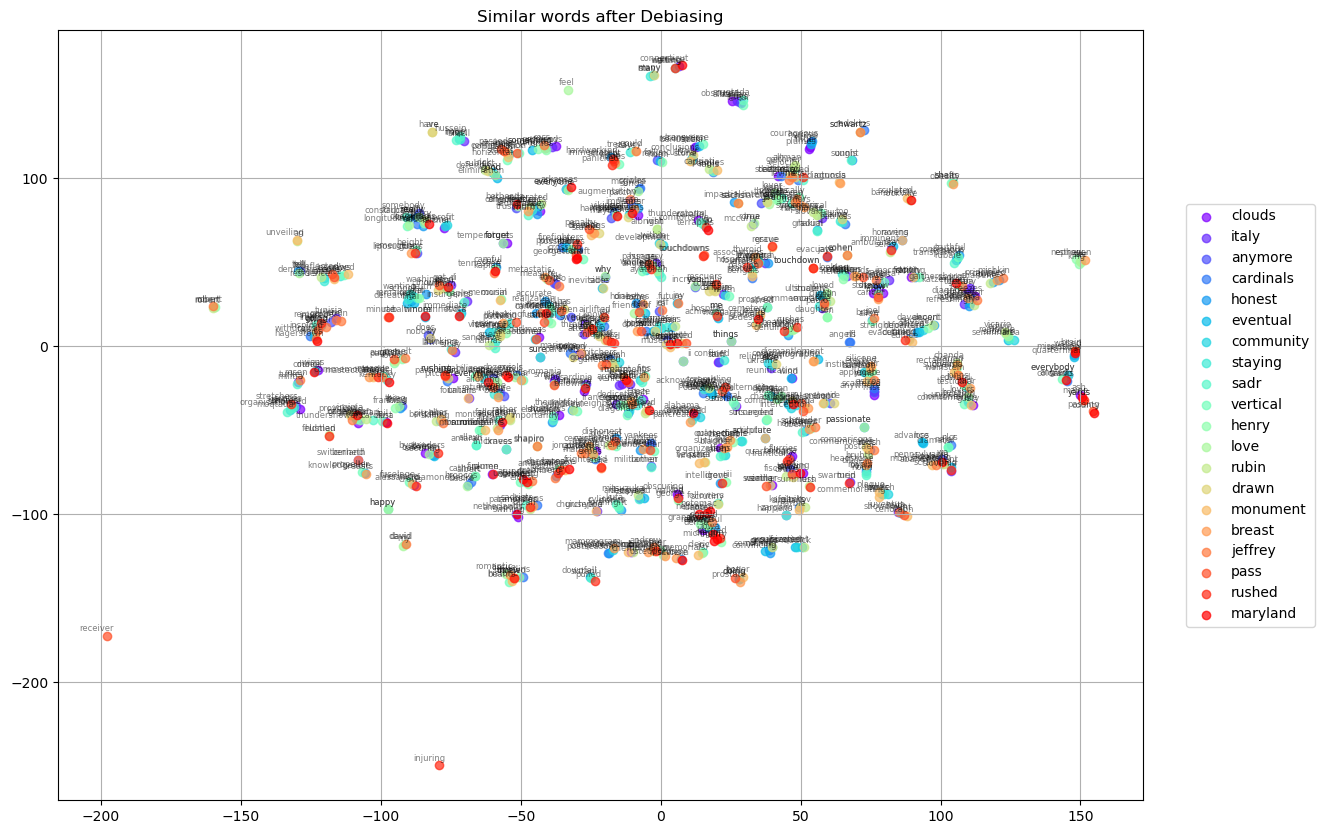

Experiment_9 , normalize_direction: True , normalize_vectors: after , centralize: True


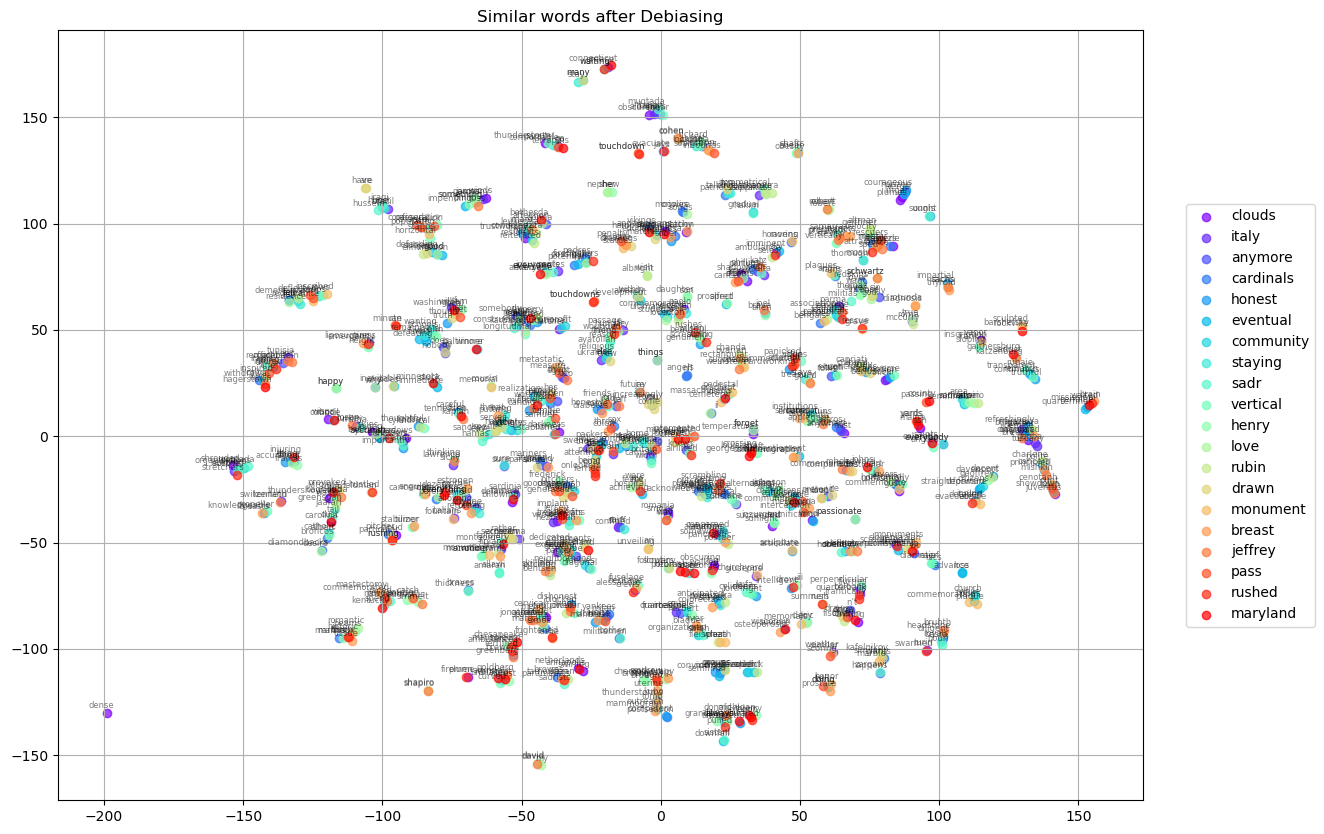

Experiment_10 , normalize_direction: True , normalize_vectors: before , centralize: False


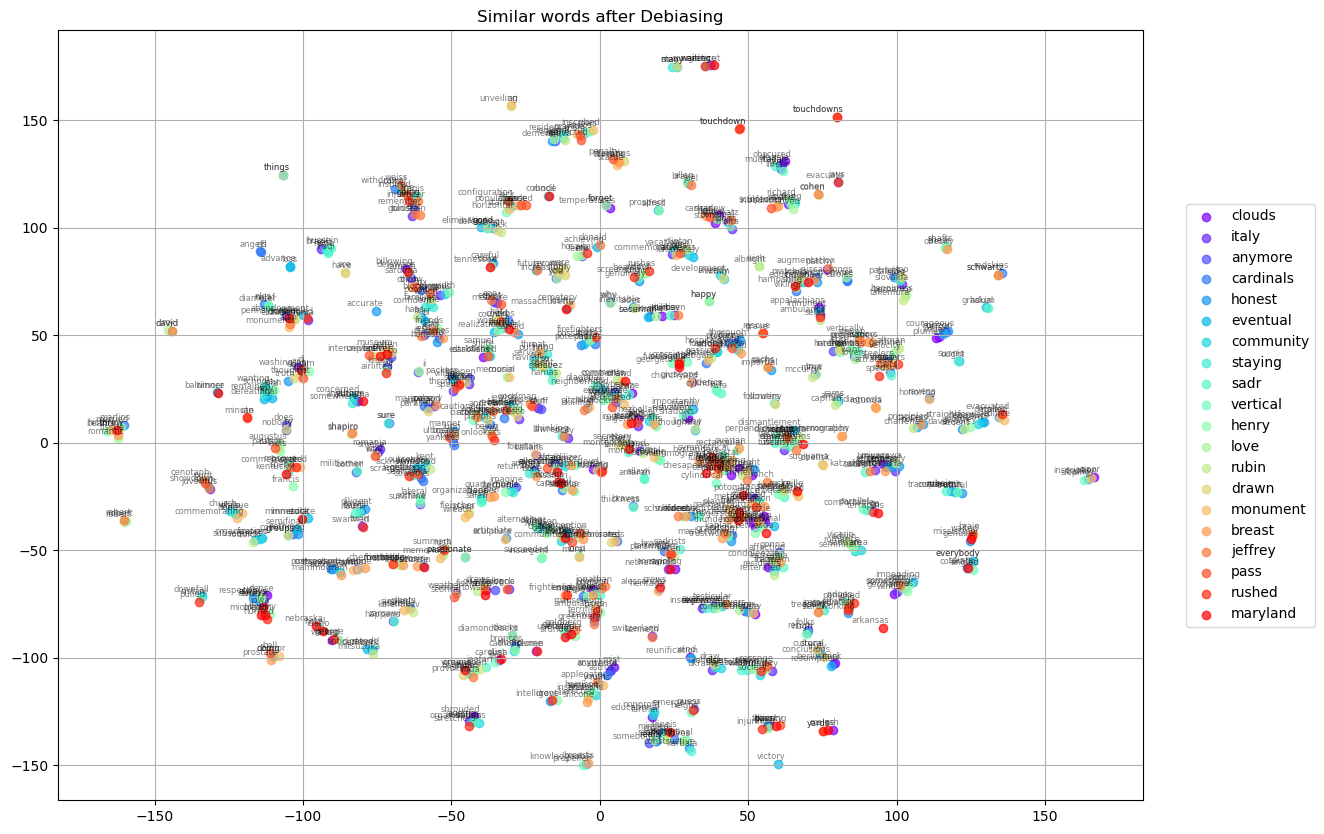

Experiment_11 , normalize_direction: True , normalize_vectors: before , centralize: True


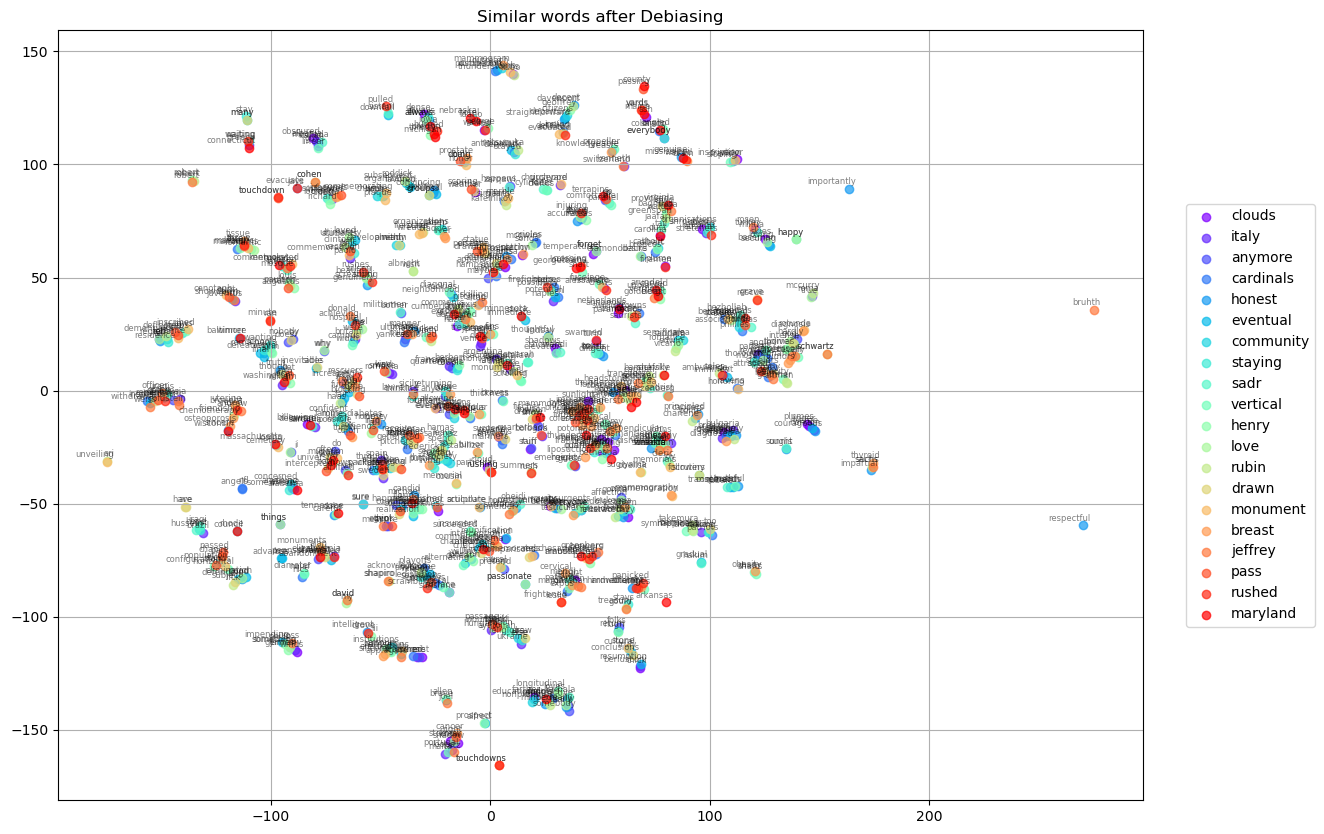

In [42]:
plot_random_words_clusters(parameters, random_words, 50)


### Bias-by-neighbor scores

In [43]:
#### Bias by neighbor
c_w2i, c_vocab, female_words, male_words, y_true = getting_biased_words(
    gender_bias_original, def_sets['gender'], 1000, word2idx_cleaned)

biased_words = female_words+male_words


k_neighbors = finding_neighbors_before_after(
    biased_words, model_original, model_debiased, topn=100)

#take k_neighbors dictionary and
calculate_bias_by_clustering(model_original, model_debiased, biased_words, 50)


NameError: name 'getting_biased_words' is not defined

In [70]:
def bias_by_neighbors(word_list, dict_vect, vocab, vectors, w2i, gender_bias_original, gender_bias_after_debiasing,neighbours_num=100):

    tuples = []
    for word in tqdm(word_list):

        _, top = get_topK_neighbors(
            word, dict_vect, vocab, vectors, w2i, k=neighbours_num)

        m = 0
        f = 0
        for t in top:
            if gender_bias_original[t] > 0:
                f += 1
            else:
                m += 1
        #average=(f+m)/neighbours_num
        tuples.append(
            (word, gender_bias_original[word], gender_bias_after_debiasing[word], f, m, f+m))

    return tuples


In [75]:
bias_neigh_before = bias_by_neighbors(neutral_words,dict_vec_cleaned, vocab_cleaned, vectors_cleaned,word2idx_cleaned,
                                     gender_bias_original,
                                      gender_bias_original,
                                     neighbours_num=50)


100%|██████████| 47/47 [01:19<00:00,  1.70s/it]


In [114]:
bias_neigh_after = bias_by_neighbors(neutral_words, grand_dict[0]['dict'], grand_dict[0]['vocab'],
                               grand_dict[0]['vectors'], grand_dict[0]['word2idx'],
                              scores_dictionary[0]['direct_bias_original'],
                               scores_dictionary[0]['direct_bias_debiased'],
                               neighbours_num=50)


100%|██████████| 47/47 [01:13<00:00,  1.57s/it]


In [77]:
bias_neigh_before


[('manager', -0.13529132111493192, -0.13529132111493192, 1, 49, 50),
 ('executive', -0.05361550516256311, -0.05361550516256311, 4, 46, 50),
 ('doctor', 0.0038349633118061055, 0.0038349633118061055, 34, 16, 50),
 ('lawyer', -0.038840352765017405, -0.038840352765017405, 14, 36, 50),
 ('programmer', -0.0522759254004345, -0.0522759254004345, 16, 34, 50),
 ('scientist', -0.07561483419946133, -0.07561483419946133, 15, 35, 50),
 ('soldier', -0.08926632515580835, -0.08926632515580835, 8, 42, 50),
 ('supervisor', 0.07901832545921295, 0.07901832545921295, 25, 25, 50),
 ('rancher', -0.08797697737329462, -0.08797697737329462, 10, 40, 50),
 ('janitor', -0.012418448705254756, -0.012418448705254756, 32, 18, 50),
 ('firefighter', 0.003920695128099519, 0.003920695128099519, 23, 27, 50),
 ('officer', -0.065440277547472, -0.065440277547472, 4, 46, 50),
 ('secretary', -0.058412457808188434, -0.058412457808188434, 3, 47, 50),
 ('nurse', 0.18737975013765296, 0.18737975013765296, 44, 6, 50),
 ('clerk', 0.012

In [113]:
bias_neigh_after[0][1]


array([-0.22834301])

In [109]:
get_bias_by_neighbors_corr_results(parameters_df, word_list, dict_vect, vocab, vectors,
                                   w2i, gender_bias_original, gender_bias_after_debiasing, neighbours_num=100)


NameError: name 'get_bias_by_neighbors_corr_results' is not defined

In [71]:

import scipy.stats


def pearson(a, b):

    return scipy.stats.pearsonr(a, b)


def compute_corr(tuples, i1, i2):

    a = []
    b = []
    for t in tuples:
        a.append(np.squeeze(t[i1]))
        b.append(np.squeeze(t[i2]))
    assert(len(a) == len(b))
    return pearson(a, b)


In [72]:
compute_corr(bias_neigh_before, 1, 5)
coor1 = compute_corr(bias_neigh_after, 1, 5)


NameError: name 'bias_neigh_before' is not defined

In [119]:
coor1.pvalue

0.5466122262413752

In [78]:
def get_bias_by_neighbors_corr_results(parameters_df,word_list, grand_dict, scores_dictionary ,neighbours_num=100):
    results=[]
    bias_neigh=[]
    for i in range(len(parameters_df)):
        bias_neigh_after = bias_by_neighbors(word_list, grand_dict[i]['dict'], grand_dict[i]['vocab'],
                      grand_dict[i]['vectors'], grand_dict[i]['word2idx'],
                      scores_dictionary[i]['direct_bias_original'],
                      scores_dictionary[i]['direct_bias_debiased'],
                      neighbours_num=neighbours_num)
        
        corr = compute_corr(bias_neigh_after, 1, 3)
        print('Experiment_'+str(i), ', normalize_direction:',
              parameters_df.iloc[i][0], ', normalize_vectors:', parameters_df.iloc[i][1], ', centralize:', parameters_df.iloc[i][2])
        print(corr)
        results.append([corr.statistic, corr.pvalue])
        bias_neigh.append(bias_neigh_after)

    return results, bias_neigh


In [79]:
results, bias_neigh= get_bias_by_neighbors_corr_results(parameters,neutral_words, grand_dict, scores_dictionary ,neighbours_num=100)

100%|██████████| 47/47 [01:20<00:00,  1.72s/it]


Experiment_0 , normalize_direction: False , normalize_vectors: None , centralize: False
PearsonRResult(statistic=0.07795432702733368, pvalue=0.6024846615655205)


100%|██████████| 47/47 [01:20<00:00,  1.71s/it]


Experiment_1 , normalize_direction: False , normalize_vectors: None , centralize: True
PearsonRResult(statistic=0.4218363795490529, pvalue=0.003144129396550017)


100%|██████████| 47/47 [01:20<00:00,  1.72s/it]


Experiment_2 , normalize_direction: False , normalize_vectors: after , centralize: False
PearsonRResult(statistic=0.04982445541109644, pvalue=0.7394452975514748)


100%|██████████| 47/47 [01:21<00:00,  1.72s/it]


Experiment_3 , normalize_direction: False , normalize_vectors: after , centralize: True
PearsonRResult(statistic=0.42183639262143047, pvalue=0.0031441283665279533)


100%|██████████| 47/47 [01:28<00:00,  1.88s/it]


Experiment_4 , normalize_direction: False , normalize_vectors: before , centralize: False
PearsonRResult(statistic=0.04982445749696885, pvalue=0.7394452870266964)


100%|██████████| 47/47 [01:33<00:00,  1.98s/it]


Experiment_5 , normalize_direction: False , normalize_vectors: before , centralize: True
PearsonRResult(statistic=0.42183639262143047, pvalue=0.0031441283665279533)


100%|██████████| 47/47 [01:32<00:00,  1.98s/it]


Experiment_6 , normalize_direction: True , normalize_vectors: None , centralize: False
PearsonRResult(statistic=0.04982445749696885, pvalue=0.7394452870266964)


100%|██████████| 47/47 [01:32<00:00,  1.97s/it]


Experiment_7 , normalize_direction: True , normalize_vectors: None , centralize: True
PearsonRResult(statistic=0.42183639262143047, pvalue=0.0031441283665279533)


100%|██████████| 47/47 [01:28<00:00,  1.89s/it]


Experiment_8 , normalize_direction: True , normalize_vectors: after , centralize: False
PearsonRResult(statistic=0.04982445749696885, pvalue=0.7394452870266964)


100%|██████████| 47/47 [01:20<00:00,  1.71s/it]


Experiment_9 , normalize_direction: True , normalize_vectors: after , centralize: True
PearsonRResult(statistic=0.42183639262143047, pvalue=0.0031441283665279533)


100%|██████████| 47/47 [01:20<00:00,  1.71s/it]


Experiment_10 , normalize_direction: True , normalize_vectors: before , centralize: False
PearsonRResult(statistic=0.04982445749696885, pvalue=0.7394452870266964)


100%|██████████| 47/47 [01:20<00:00,  1.70s/it]

Experiment_11 , normalize_direction: True , normalize_vectors: before , centralize: True
PearsonRResult(statistic=0.42183639262143047, pvalue=0.0031441283665279533)


In [86]:
bias_neigh


[[('manager', array([-0.22834301]), array([-3.21657399e-08]), 28, 72, 100),
  ('executive', array([-0.12012595]), array([-8.79373461e-08]), 8, 92, 100),
  ('doctor', array([-0.18165517]), array([-1.18618529e-08]), 32, 68, 100),
  ('lawyer', array([-0.11673066]), array([-2.01400438e-08]), 15, 85, 100),
  ('programmer', array([-0.12321252]), array([3.77767068e-08]), 44, 56, 100),
  ('scientist', array([-0.01485001]), array([-5.45064287e-08]), 17, 83, 100),
  ('soldier', array([-0.08605033]), array([-3.53421844e-08]), 17, 83, 100),
  ('supervisor', array([-0.0725164]), array([-1.68933843e-08]), 34, 66, 100),
  ('rancher', array([0.05175218]), array([4.11697114e-09]), 55, 45, 100),
  ('janitor', array([-0.07843446]), array([3.92976119e-08]), 68, 32, 100),
  ('firefighter', array([-0.07872555]), array([7.97785064e-09]), 51, 49, 100),
  ('officer', array([-0.10709966]), array([5.32653321e-09]), 18, 82, 100),
  ('secretary', array([-0.02485213]), array([-7.10588412e-08]), 10, 90, 100),
  ('nu

In [90]:
#get a dataframe with the results of bias_neigh with a column specifying the experiment number
bias_neigh_df = pd.DataFrame(bias_neigh[0], columns=['word', 'bias_before', 'bias_after', 'f', 'm', 'sum_m_f'])
bias_neigh_df['experiment'] = 0

#add the results of the other experiments
for i in range(1, len(bias_neigh)):
    bias_neigh_df_temp = pd.DataFrame(bias_neigh[i], columns=['word', 'bias_before', 'bias_after', 'f', 'm','sum_m_f'])
    bias_neigh_df_temp['experiment'] = i
    bias_neigh_df = bias_neigh_df.append(bias_neigh_df_temp)

/var/folders/bh/g_8v28y122j2fc_vq7b3x8cr0000gn/T/ipykernel_1558/3249953743.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/bh/g_8v28y122j2fc_vq7b3x8cr0000gn/T/ipykernel_1558/3249953743.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/bh/g_8v28y122j2fc_vq7b3x8cr0000gn/T/ipykernel_1558/3249953743.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/bh/g_8v28y122j2fc_vq7b3x8cr0000gn/T/ipykernel_1558/3249953743.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/bh/g_8v28y122j2fc_vq7b3x8cr0000gn/T/ipykernel_1558/3249953743.py:9: FutureWarning:

The frame.append method is deprecated a

In [91]:
bias_neigh_df


word             bias_before                 bias_after   f   m  \
0      manager  [-0.22834300994873047]   [-3.216573987599534e-08]  28  72   
1    executive  [-0.12012594938278198]   [-8.793734612439884e-08]   8  92   
2       doctor   [-0.1816551685333252]  [-1.1861852949532348e-08]  32  68   
3       lawyer  [-0.11673066020011902]   [-2.014004382196047e-08]  15  85   
4   programmer  [-0.12321252375841141]    [3.777670676041776e-08]  44  56   
..         ...                     ...                        ...  ..  ..   
42     violent   [0.07828310877084732]     [0.017632306427544937]  93   7   
43   terrorist    [0.1175680086016655]      [0.01119570392652088]  68  32   
44       dirty   [0.01885116472840309]     [0.012026659418716593]  79  21   
45  uneducated   [-0.0518249049782753]    [-0.003938236000065728]  42  58   
46    educated      [0.07125224173069]     [0.028763673716550624]  85  15   

    sum_m_f  experiment  
0       100           0  
1       100           0  
2       100           0  
3       100           0  
4       100           0  
..      ...         ...  
42      100          11  
43      100          11  
44      100          11  
45      100          11  
46      100          11  

[564 rows x 7 columns]

### Saving Embeddings on a txt file.
- And loading them as a Gensim model object

In [ ]:
#Saving the debiased vectors and vocab to a text file
glove.save_in_word2vec_format(
    debiased_vectors, debiased_vocab, "./Data/vecs.50.cleaned.txt")

#Loading the vectors into a KeyedVectors object 'model_cleaned' that we can use to find the most similar words to a given word
model_cleaned, _, _ = load_word_vectors(
    fname="./Data/vecs.50.cleaned.txt")

